# Sentiment and semantic analysis

## Make a lyrical embedding

---

The code below loads a pretrained sentence-transformer language model (all-MiniLM-L6-v2), which has the ability to encode text into  a 384-dimensional embedding vector. This vector represents the semantics of an artist lyrics, in numerical format. For every artist in our network we compute this embedding vector and append it to the graph as an attribute, allowing us to analysis similarity in artist semantics numerically. 

In [ ]:
import networkx as nx
from pathlib import Path
import torch
from sentence_transformers import SentenceTransformer
import numpy as np
import json 

# path to input graph with sentiment
input_path = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_with_sentiment.graphml")
# output path to save graph with embeddings
output_path = input_path.parent / "artist_network_with_embeddings.graphml"

print("Loading graph...")
G = nx.read_graphml(str(input_path)) # load graph from file
print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# helper to get device
def get_device():
    if torch.cuda.is_available(): return "cuda" # if a GPU is available
    if torch.backends.mps.is_available(): return "mps" # for Apple Silicon
    return "cpu"

device = get_device() 
print(f"Running on: {device}")

# load transformer model that converts sentences to vectors
print("Loading sentence transformer model...")
model = SentenceTransformer('all-MiniLM-L6-v2', device=device) # small, fast, good performance


node_ids = [] # index of nodes to embed
lyrics_list = [] # corresponding lyrics

print("Gathering lyrics...")
for node in G.nodes(): # loop over all nodes
    # Fetch lyrics
    raw_text = str(G.nodes[node].get('lyrics', ''))
    
    # Filter valid lyrics
    if len(raw_text) > 5: # only embed if there are lyrics
        node_ids.append(node) # store node id
        lyrics_list.append(raw_text[:2000]) # append lyrics (limit to first 2000 characters to save memory/time)

print(f"Nodes to embed: {len(node_ids)}")

# ENCODE & STORE IN GRAPH ---
if len(node_ids) > 0: # only proceed if there are lyrics to embed

    embeddings = model.encode(lyrics_list, show_progress_bar=True, device=device) # get embeddings
    
    print("Attaching vectors to nodes...")
    count = 0 # counter for nodes with embeddings
    for node, emb in zip(node_ids, embeddings): # loop over nodes and their embeddings

        G.nodes[node]['lyric_vector'] = json.dumps(emb.tolist()) # store as JSON string in graph
        count += 1 # increment counter to track number of nodes updated
        
    print(f"Successfully added vectors to {count} nodes.")

    # SAVE GRAPH ---
    print(f"Saving new graph to: {output_path}")
    nx.write_graphml(G, str(output_path))
    print("Done saving graph.")

else:
    print("No lyrics found to embed.")

---


## Make sentiment analysis

---

The code below loads  a pretrained sentiment analyzer called VADER (Valence Aware Dictionary and sEntiment Reasoner). This was designed to analyse short informal text, and uses a sentiment lexicon, where each word is assigned a valance score. Valence in this context refers to the emotional intensity and direction of the words meaning, going from -1(negativ) to 1(postive) with 0 being neutral. 
Vader gives every word a valence score but adjust this score based on centrain rules. For example it flips the sign of the valence for a sentence if "not" is detected, and can distingiush strengths of words like "good", "very good" and "great". So even though VADER is small and fast, it makes for a decent model to analyse sentiment of lyrics. 



In [ ]:
import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
# SETUP 
analyzer = SentimentIntensityAnalyzer() # initialize VADER sentiment analyzer 
G_path = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_with_sentiment.graphml")

print("Reloading graph...")
G = nx.read_graphml(str(G_path))


def get_nuanced_sentiment(text):
    """ A function that calculates sentiment by averaging line-by-line scores.
        This captures nuance better than a single score for the whole text.
        """
    if len(text) < 5:  # if text is too short, return neutral
        return 0.0
    
    # Split into lines
    lines = text.split('\n') # split by newline
    line_scores = [] # to hold individual line scores
    
    for line in lines: # iterate over lines
        # Skip empty lines or very short garbage
        if len(line.strip()) > 2:
            # Get the compound score for JUST this line
            score = analyzer.polarity_scores(line)['compound']
            line_scores.append(score) # store the score
            
    if not line_scores: # if no valid lines found
        return 0.0
        
    # Return the average of the lines
    return np.mean(line_scores)

# APPLY TO ALL NODES ---
print("Recalculating sentiment (Line-by-Line Average)...")
new_scores = []

for node in tqdm(G.nodes()):
    # Get raw lyrics
    lyrics = str(G.nodes[node].get('lyrics', ''))
    
    # Calculate new score
    new_score = get_nuanced_sentiment(lyrics)
    
    # Update the node attribute
    G.nodes[node]['sentiment_compound'] = float(new_score)
    new_scores.append(new_score)

# CHECK THE NEW DISTRIBUTION ---
plt.figure(figsize=(10, 5))
plt.hist(new_scores, bins=50, color='mediumseagreen', edgecolor='black')
plt.title("New Distribution: Line-by-Line Average\n(Should look like a Bell Curve)")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.show()

# 
output_path = G_path.parent / "artist_network_nuanced_sentiment.graphml"
nx.write_graphml(G, str(output_path))
print(f"Saved to {output_path}")

# Applying embedding for analysis

## Use lyrical embedding to analyse similarity across artist.

The code below uses the embeddings created above to analyse the lyrical similarity across artist. It takes the embedding vector for one artist, and calculate the *cosine similarity* against all other artists embedding vector:

$$
\text{cos}(\theta) = \frac{A \cdot B }{||A|| \ ||B||}
$$
Then we plot the edge weight between two artists against their cosine similarity and compute the pearson correlation between these two variables (Cosine similarity and edge weight). 

**Pearson correlation** measures the linear relationship between two variables giving us a value between -1 and +1. It is calculated as:

$$
r_{XY} = 
\frac{
\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})
}{
\sqrt{
\sum_{i=1}^{n} (x_i - \bar{x})^2
\sum_{i=1}^{n} (y_i - \bar{y})^2
}
}
$$

where $x_i$ is the *edge weight*, $y_i$ the *cosine similarity*, $\bar{x},\bar{y}$ their mean and $n$ the number of nodes

---

The next half of the code computes the avarages embedding for all artists and saves this as a vector, representing the global average semantic meaning for our the population of artist in the network. We now make the assumption that the closer an artists embedding lies to this global average, the more generic and less unique an artists lyrics are. This enables us to compute the "uniqueness" of every artist as the *cosine similarity* between the artist embedding vector and the global average embedding vector. This is plotted vs the number of times an artist appears on a playlist, as a measure of popularity, leaving us with an approximation of "Uniqueness vs popularity" plot.


Loaded G_mother.
Found 983 nodes with embeddings.

=== BUILDING PLOT 1 (Edge Similarity vs Weight) ===


100%|██████████| 16333/16333 [00:04<00:00, 3286.29it/s]


Pearson correlation (weight vs similarity): 0.1642


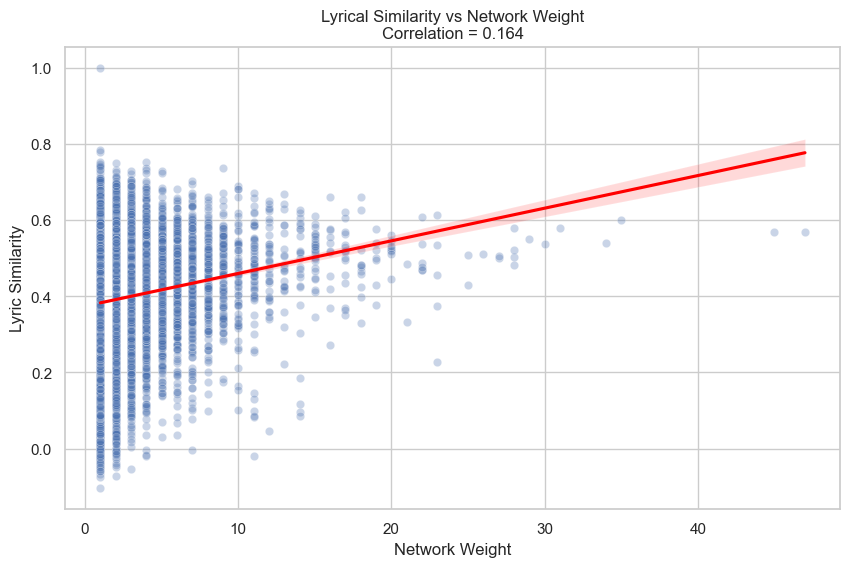


=== BUILDING PLOT 2 (Popularity vs Uniqueness) ===
Computed global mean embedding.


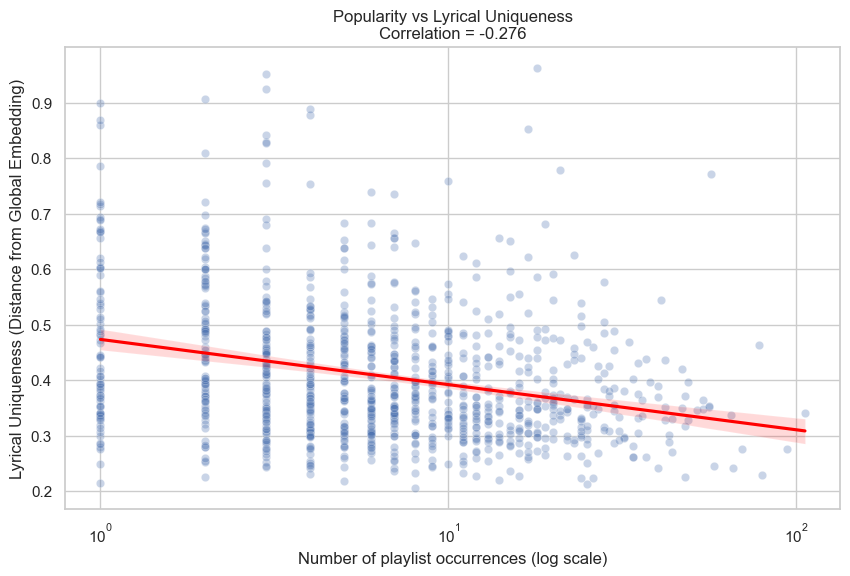

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from tqdm import tqdm

# plot seaborn style
sns.set(style="whitegrid")



# load graph
G_path = r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\G_mother.graphml"
G = nx.read_graphml(G_path)
print("Loaded G_mother.")

# helper to parse vector from JSON string
def parse_vector(v):
    """The attribute 'lyric_vector' is stored as a JSON string. This function parses it back to a numpy array."""
    try:
        return np.array(json.loads(v))
    except:
        return None


# Build embedding dictionary
embedding_dict = {}

for node in G.nodes():# loop over all nodes
    v_str = G.nodes[node].get("lyric_vector") # get the JSON string
    if v_str: # if it exists
        v = parse_vector(v_str) # parse to numpy array
        if v is not None: # if parsing was successful
            embedding_dict[node] = v # store in dictionary

print(f"Found {len(embedding_dict)} nodes with embeddings.")



print("\n=== BUILDING PLOT 1 (Edge Similarity vs Weight) ===") # plot time 

data_points_1 = [] # to hold data points for plot 

for u, v, data in tqdm(G.edges(data=True)): # loop over edges
    if u in embedding_dict and v in embedding_dict: # if both nodes have embeddings
        sim = cosine_similarity([embedding_dict[u]], [embedding_dict[v]])[0][0] # compute cosine similarity
        data_points_1.append({
            "Network Weight": data.get("weight", 0),
            "Lyric Similarity": sim
        }) # store weight and similarity

df1 = pd.DataFrame(data_points_1) # create dataframe
 
if not df1.empty: # only plot if we have data
    corr1 = df1["Network Weight"].corr(df1["Lyric Similarity"]) # compute Pearson correlation
    print(f"Pearson correlation (weight vs similarity): {corr1:.4f}") 

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df1, x="Network Weight", y="Lyric Similarity", alpha=0.3)
    sns.regplot(data=df1, x="Network Weight", y="Lyric Similarity",
                scatter=False, color="red")
    plt.title(f"Lyrical Similarity vs Network Weight\nCorrelation = {corr1:.3f}")
    plt.show()
else:
    print("Not enough edges to compute similarity plot.")


# ==================================
# Popularity vs Lyrical Uniqueness 

# Compute global average embedding 
all_vecs = list(embedding_dict.values()) # get all vectors
global_mean_vec = np.mean(all_vecs, axis=0) # compute mean vector

print("Computed global mean embedding.")


# Compute per-artist stats 
data_points_2 = [] # to hold data points

for node in G.nodes(): # loop over all nodes
    if node in embedding_dict: # if node has embedding

        # Playlist popularity (weighted degree)
        deg = int(G.nodes[node].get('num_playlists', 0)) # number of playlists the artist appears in

        # Sentiment
        sent = float(G.nodes[node].get("sentiment_compound", 0)) # sentiment score

        # Uniqueness = 1 - cosine similarity to the global average embedding
        vec = embedding_dict[node] # get artist's vector
        similarity = cosine_similarity([vec], [global_mean_vec])[0][0] # cosine similarity
        uniqueness = 1 - similarity # compute uniqueness

        data_points_2.append({
            "Artist": node,
            "Playlist_Popularity": deg,
            "Lyrical_Uniqueness": uniqueness,
            "Sentiment": sent
        }) # store data point

df2 = pd.DataFrame(data_points_2) # create dataframe

# plot Popularity vs Uniqueness
if not df2.empty:

    corr2, _ = pearsonr(np.log1p(df2["Playlist_Popularity"]), df2["Lyrical_Uniqueness"]) # compute Pearson correlation

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df2, x="Playlist_Popularity", y="Lyrical_Uniqueness", alpha=0.3) # scatter plot
    plt.xscale("log")

    sns.regplot(data=df2, x="Playlist_Popularity", y="Lyrical_Uniqueness",
                scatter=False, color="red", logx=True) # regression line

    plt.title(f"Popularity vs Lyrical Uniqueness\nCorrelation = {corr2:.3f}")
    plt.xlabel("Number of playlist occurrences (log scale)")
    plt.ylabel("Lyrical Uniqueness (Distance from Global Embedding)")
    plt.show()

else:
    print("No data available for popularity vs uniqueness plot.")


---

## Partition analysis


---


The following code compares three different ways of grouping artist in the network together. 

1. Based on network structure throught the Louvain aglorithm 

2. Based on lyric semantics, using K-means clustering

3. Based on sentiment, through binning

The goal is to see what type of grouping explains the structure of the network by comparing modularity scores.



In [ ]:
import networkx as nx
import json
import numpy as np
from sklearn.cluster import KMeans
from community import community_louvain
import pandas as pd
from pathlib import Path



G_path = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\G_mother.graphml")
G = nx.read_graphml(G_path)

# same parser that we used before for embeddings
def parse_vec(attr):
    try:
        return np.array(json.loads(attr))
    except:
        return None


# detect communities based on structural features using Louvain
struct_partition = community_louvain.best_partition(G, weight="weight") # creatre structural partition
mod_structure = community_louvain.modularity(struct_partition, G, weight="weight") # compute modularity
num_struct_coms = len(set(struct_partition.values())) # number of structural communities


# detect communities based on lyrical embeddings using K-means
embedding_dict = {} # to hold node embeddings
for node in G.nodes(): # loop over all nodes
    vec_str = G.nodes[node].get("lyric_vector") # get the JSON string
    if vec_str: # if it exists
        vec = parse_vec(vec_str) # parse to numpy array
        if vec is not None: # if parsing was successful
            embedding_dict[node] = vec # store in dictionary

# Stack vectors for K-means
nodes_with_vecs = list(embedding_dict.keys()) # get nodes with embeddings
X = np.vstack([embedding_dict[n] for n in nodes_with_vecs]) # stack vectors

# Use SAME number of clusters as Louvain for fairness
kmeans = KMeans(n_clusters=num_struct_coms, random_state=42, n_init=10) # initialize KMeans
labels = kmeans.fit_predict(X) # fit and predict

# create lyric_partition dictionary mapping nodes to their cluster labels
lyric_partition = {node: int(label) for node, label in zip(nodes_with_vecs, labels)} # create partition dictionary



# Compute modularity on subgraph (embedding nodes only)
G_sub = G.subgraph(nodes_with_vecs) # create subgraph with nodes that have embeddings
mod_lyrics = community_louvain.modularity(lyric_partition, G_sub, weight="weight") # compute modularity


# detect communities based on sentiment using quantile binning
sent_values = {node: float(G.nodes[node].get("sentiment_compound", 0)) for node in G.nodes()} # get sentiment scores
scores = pd.Series(sent_values) # convert to pandas Series

# 5 sentiment bins (20% each)
sent_bins = pd.qcut(scores, q=5, labels=[0,1,2,3,4]) # quantile binning
sent_partition = sent_bins.to_dict() # convert to dictionary

mod_sentiment = community_louvain.modularity(sent_partition, G, weight="weight") # compute modularity


print("\n=== FINAL MODULARITY SCORES ===")
print(f"Structural (Louvain):     {mod_structure:.4f}")
print(f"Lyrical (K-means):        {mod_lyrics:.4f}")
print(f"Sentiment (Quantiles):    {mod_sentiment:.4f}")


c:\Users\Madsl\anaconda3\envs\lyrics_project\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(



=== FINAL MODULARITY SCORES ===
Structural (Louvain):     0.4996
Lyrical (K-means):        0.1190
Sentiment (Quantiles):    0.0736
